In [1]:
%conda install -y gdal geopandas

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import os
import numpy as np
import uuid
import cv2 as cv
from PIL import Image
from matplotlib import pyplot as plt
# from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model, model_from_json
from io import BytesIO
import zipfile

In [3]:
# Set Variables
s3_resource = boto3.resource('s3')
output_bucket = "csu-team04-inference-output"
input_bucket = "csu-team04-inference-input"
model_bucket_name = "csu-team04-inference-model"
img_object_name = "output_149.tiff"
# model_object_name = "new_model.h5"
model_object_name = "model.tar.gz"

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [4]:
def load_model(json_file, weights_file):
    with open(json_file, 'r') as file:
        json_content = file.read()
        
    model = model_from_json(json_content)
    model.load_weights(weights_file)
    
    return model

In [5]:
# Overlay Mask on Image
colour = [66, 255, 73]
colour = [i/255.0 for i in colour]

def place_mask_on_image(image, mask):
    np.place(image[:, :, :], mask[:, :, :] >= 0.5, colour)
    return image

In [6]:
def predict(prediction):
    prediction = prediction[0][:, :, :]
    prediction = np.repeat(prediction, 3, 2)
    return prediction

In [7]:
# Get Image From Bucket
img_file_path = f"/tmp/{uuid.uuid4()}-{img_object_name}"

s3 = boto3.client("s3")
s3.download_file(input_bucket, img_object_name, img_file_path)
image = cv.imread(img_file_path)

Formatting image...


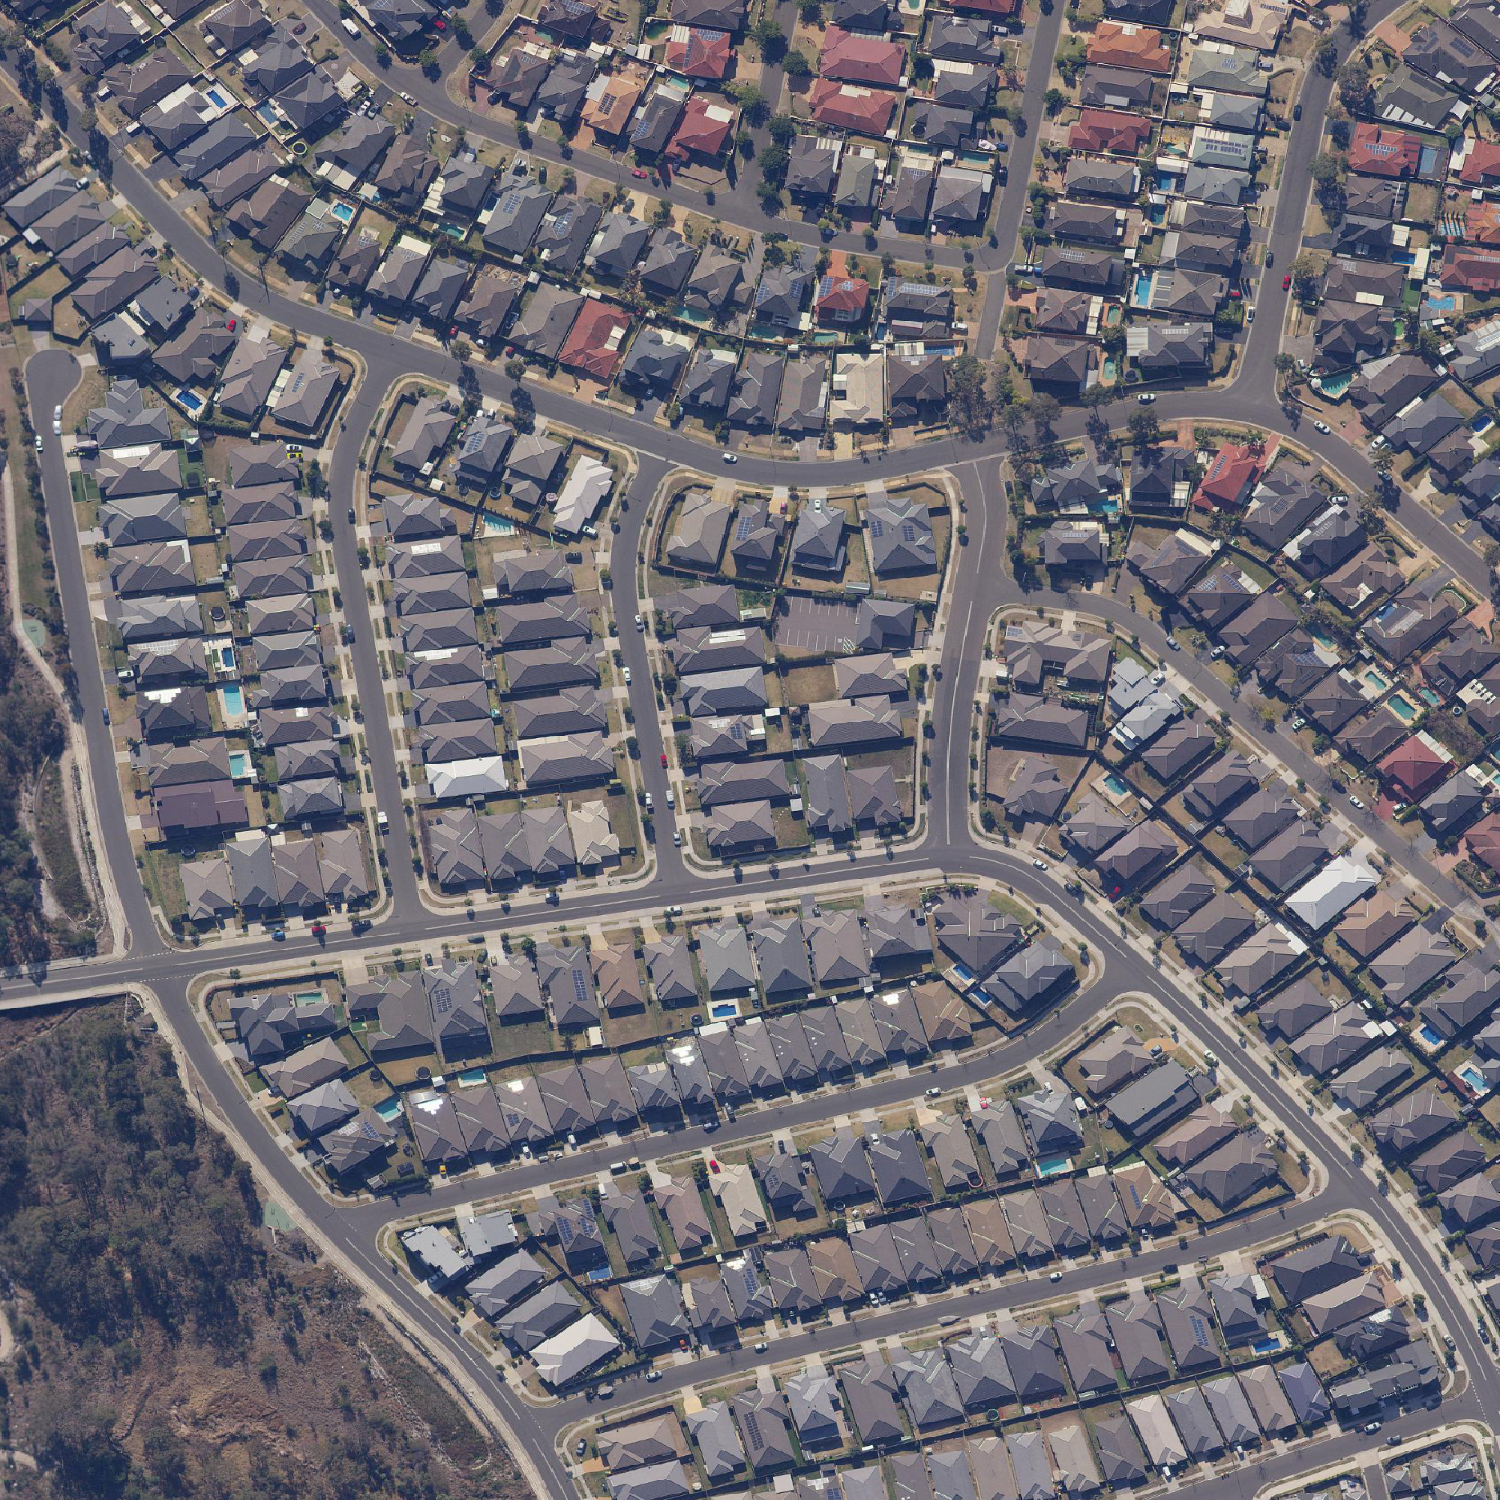

In [8]:
# Get Image As Numpy Array
print("Formatting image...")
img_shape = (512, 512)
image = image[:,:,:3]
image = np.expand_dims(cv.resize(image, img_shape), 0)
image = (image/255.0)
image = image.astype(np.float32)
display(Image.open(img_file_path))

In [9]:
# Load Model
import tarfile
import os
print("Loading model...")
model_path = f"/tmp/{model_object_name}"
s3.download_file(model_bucket_name, model_object_name, model_path)
model_file = tarfile.open(model_path)
model_file.extractall("/tmp/extracted_model")
print(os.listdir("/tmp/extracted_model/"))
model = load_model("/tmp/extracted_model/model.json", "/tmp/extracted_model/model.h5")
# model = load_model("/tmp/new_model.h5", compile=False)
print("Model loaded successfully!")

Loading model...
['model.h5', 'model.json']
Model loaded successfully!


In [10]:
# Make Prediction
prediction = predict(model(image))
print(prediction)

[[[0.45656642 0.45656642 0.45656642]
  [0.44399178 0.44399178 0.44399178]
  [0.4047247  0.4047247  0.4047247 ]
  ...
  [0.4456014  0.4456014  0.4456014 ]
  [0.42570403 0.42570403 0.42570403]
  [0.5141837  0.5141837  0.5141837 ]]

 [[0.4008964  0.4008964  0.4008964 ]
  [0.56360537 0.56360537 0.56360537]
  [0.36819375 0.36819375 0.36819375]
  ...
  [0.49666405 0.49666405 0.49666405]
  [0.34902555 0.34902555 0.34902555]
  [0.4703361  0.4703361  0.4703361 ]]

 [[0.2971367  0.2971367  0.2971367 ]
  [0.29663834 0.29663834 0.29663834]
  [0.16149831 0.16149831 0.16149831]
  ...
  [0.28372538 0.28372538 0.28372538]
  [0.22063994 0.22063994 0.22063994]
  [0.46297693 0.46297693 0.46297693]]

 ...

 [[0.3327837  0.3327837  0.3327837 ]
  [0.287712   0.287712   0.287712  ]
  [0.10681227 0.10681227 0.10681227]
  ...
  [0.29741633 0.29741633 0.29741633]
  [0.1768972  0.1768972  0.1768972 ]
  [0.35197514 0.35197514 0.35197514]]

 [[0.32175717 0.32175717 0.32175717]
  [0.2754398  0.2754398  0.2754398 ]


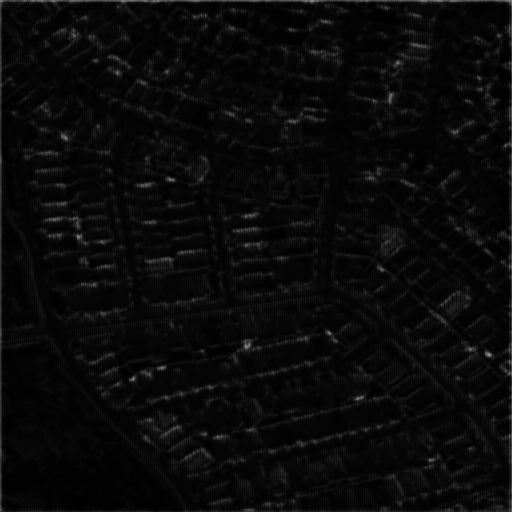

In [11]:
# Convert Results to Tiff
upload_path = f"/tmp/{img_object_name}"
result_image = Image.fromarray((prediction * 255).astype(np.uint8))
result_image.save(upload_path)
display(Image.open(upload_path))

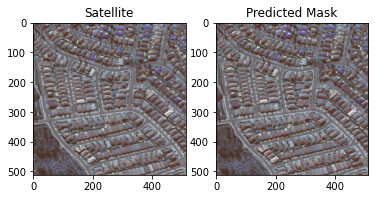

In [12]:
# Display Overlay
plt.subplot(1, 2, 1)
plt.title("Satellite")
plt.imshow(image[0])
plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
prediction = place_mask_on_image(image[0], prediction)
plt.imshow(prediction)
plt.show()

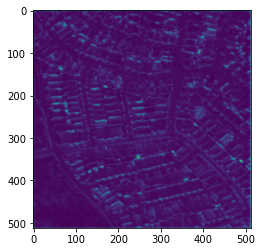

In [13]:
from osgeo import gdal, ogr, osr
import geopandas as gpd
raster = gdal.Open(upload_path)
geo_transform = raster.GetGeoTransform()
projection = raster.GetProjection()
raster_band = raster.GetRasterBand(1)
arr = raster_band.ReadAsArray()

shape_projection = osr.SpatialReference()
shape_projection.ImportFromWkt(projection)

plt.figure()
plt.imshow(arr)
plt.show()

In [14]:
output_file = "./output_shapefile.shp"
shapefile_driver = ogr.GetDriverByName("ESRI Shapefile")
output_shapefile = shapefile_driver.CreateDataSource(output_file)
shape_layer = output_shapefile.CreateLayer('layername', srs=shape_projection)

new_field = ogr.FieldDefn(str("ID"), ogr.OFTInteger)
shape_layer.CreateField(new_field)

0

In [15]:
gdal.Polygonize(raster_band, None, shape_layer, 0, [], callback=None)
output_shapefile.Destroy()
raster_band = None

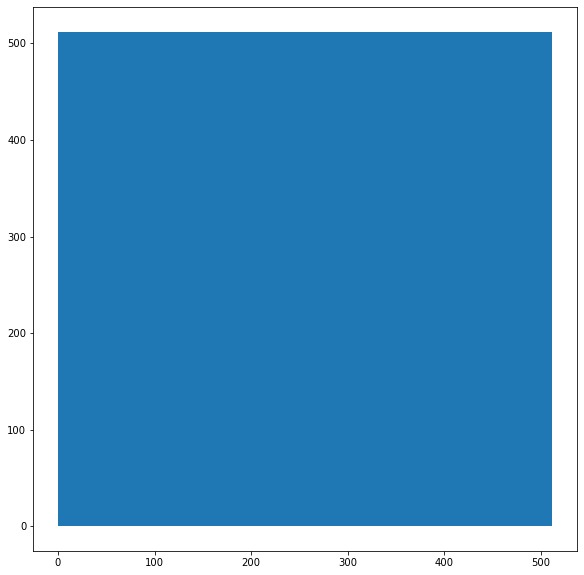

In [16]:
shapefile = gpd.read_file("./output_shapefile.shp")
fix, ax = plt.subplots(figsize=(10, 10))

shapefile.plot(ax=ax)
plt.show()

In [17]:
# Upload Result to Bucket
s3.upload_file(output_file, output_bucket, f"{img_object_name.split('.')[0]}-mask.shp")
print("Uploaded image to bucket!")

Uploaded image to bucket!
